# Premier workflow d'identication d'un champignon
Utilisation d'un générateur d'images  
Fichiers en local sur le HDD  
Utilisation d'un modèle pré-entrainé VGG16

Pour ce test, nous avons sélectionné les champignons suivants:
"Agaricaceae", "Amanitaceae", "Fomitopsidaceae", "Polyporaceae"  
Voici le lien pour télécharger les images : https://drive.google.com/file/d/1uYXilekd5IxCornaRyFlWmzpyJb-txSi/view?usp=sharing  
Puis dézipper le fichier au même niveau que le notebook, de sorte que le notebook et le répertoire Images soient au même niveau

Nous prévoyons de dupliquer ce Notebook pour comparer les performances entre "flow_from_directory" et "flow_from_dataframe"

Nous avons passé beaucoup de temps pour utiliser la fonction "predict", le problème étant sur le format d'image attendu. Nous avons testé 2 méthodes, dont "preprocess_input" qui nous a causé des misères


In [191]:
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

## Déclaration des chemins où récupérer les images sur le HDD en local
Notre jeu de donné est séparé en deux dossiers : train et test

In [200]:
import pathlib

base_dir = '.\Images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

# Définition des 4 répertoires locaux pour les 4 classes de champignons (fichiers d'entrainement)
train_c1_dir = os.path.join(train_dir, 'Agaricaceae')
train_c2_dir = os.path.join(train_dir, 'Amanitaceae')
train_c3_dir = os.path.join(train_dir, 'Fomitopsidaceae')
train_c4_dir = os.path.join(train_dir, 'Polyporaceae')


# Définition des 4 répertoires locaux pour les 4 classes de champignons (fichiers de test)
validation_c1_dir = os.path.join(validation_dir, 'Agaricaceae')
validation_c2_dir = os.path.join(validation_dir, 'Amanitaceae')
validation_c3_dir = os.path.join(validation_dir, 'Fomitopsidaceae')
validation_c4_dir = os.path.join(validation_dir, 'Polyporaceae')

classes = ["Agaricaceae", "Amanitaceae", "Fomitopsidaceae", "Polyporaceae"]


## Affichage de 3 images des 4 classes
Pour vérifier l'importation.

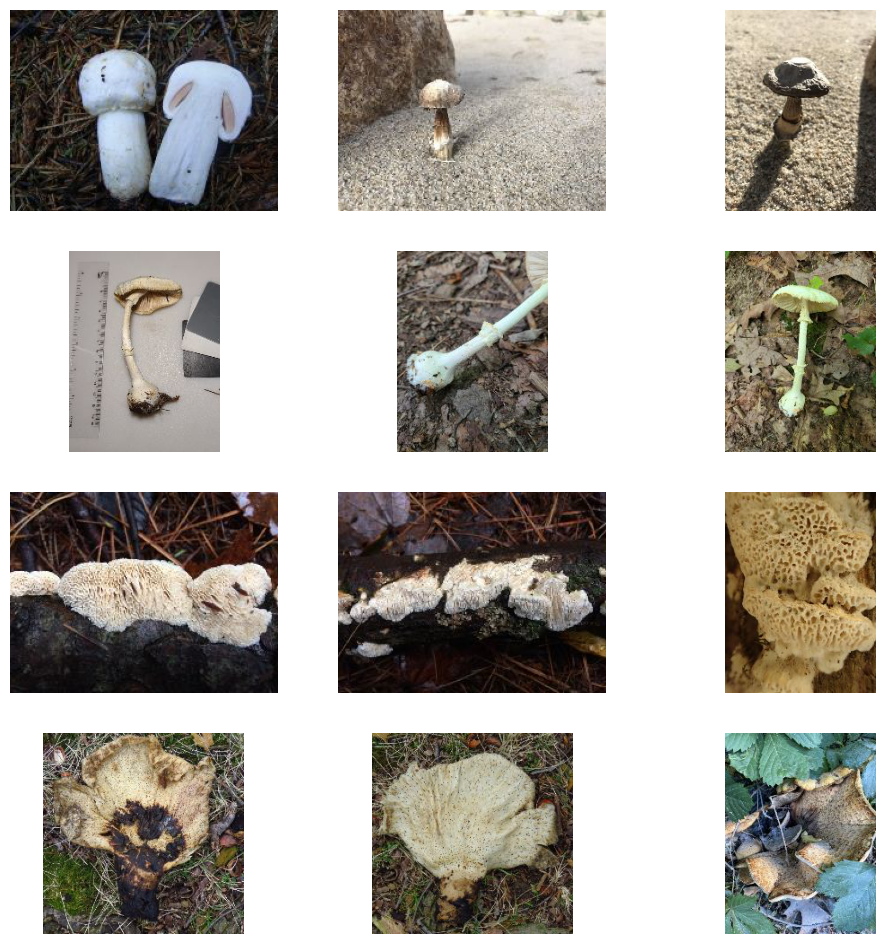

In [201]:
import matplotlib.image as mpimg

nrows = 4
ncols = 3

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*3)
train_c1_fnames = os.listdir( train_c1_dir )
train_c2_fnames = os.listdir( train_c2_dir )
train_c3_fnames = os.listdir( train_c3_dir )
train_c4_fnames = os.listdir( train_c4_dir )


next_c1_pix = [os.path.join(train_c1_dir, fname) 
                for fname in train_c1_fnames[ 1:4] 
               ]

next_c2_pix = [os.path.join(train_c2_dir, fname) 
                for fname in train_c2_fnames[ 0:3]
               ]

next_c3_pix = [os.path.join(train_c3_dir, fname) 
                for fname in train_c3_fnames[ 0:3]
              ]

next_c4_pix = [os.path.join(train_c4_dir, fname) 
                for fname in train_c4_fnames[ 0:3]
              ]

for i, img_path in enumerate((next_c1_pix + next_c2_pix + next_c3_pix + next_c4_pix)):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Générateur d'image
On met rotation_range à 180 pour générer des images dans tous les sens, ce qui devrait permettre d'éviter le flip (à valider)  


In [196]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Parametres du générateur d'images pour l'entrainement
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [0.9,1.1],
                                   horizontal_flip = False)

# Générateur d'images pour le test
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [197]:
# Entrainment depuis des images sur le HDD
batch_size = 20
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = (224, 224))

# Validation avec les images de test sur le HDD
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size = batch_size,
                                                        class_mode = 'binary',
                                                        target_size = (224, 224))

Found 2245 images belonging to 4 classes.
Found 384 images belonging to 4 classes.


## Création du modèle VGG16 pré-entrainé avec ImageNet

In [198]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

base_model = VGG16(input_shape = (224, 224, 3),
                   include_top = False,
                   weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 4, activation = 'softmax'))
    
model.compile(optimizer = "adam",
             loss = 'sparse_categorical_crossentropy',
             metrics = ["acc"])

## Entrainement

In [199]:
history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 69s 682ms/step - loss: 1.6675 - acc: 0.5259 - val_loss: 0.8978 - val_acc: 0.5885
Epoch 2/10
100/100 [==============================] - 76s 761ms/step - loss: 0.8356 - acc: 0.6605 - val_loss: 1.1367 - val_acc: 0.5547
Epoch 3/10
100/100 [==============================] - 77s 768ms/step - loss: 0.7771 - acc: 0.6806 - val_loss: 1.1835 - val_acc: 0.5833
Epoch 4/10
100/100 [==============================] - 77s 767ms/step - loss: 0.6977 - acc: 0.7128 - val_loss: 1.0568 - val_acc: 0.5703
Epoch 5/10
100/100 [==============================] - 80s 801ms/step - loss: 0.6625 - acc: 0.7375 - val_loss: 1.1054 - val_acc: 0.5573
Epoch 6/10
100/100 [==============================] - 82s 814ms/step - loss: 0.6133 - acc: 0.7615 - val_loss: 1.0133 - val_acc: 0.5677
Epoch 7/10
100/100 [==============================] - 77s 769ms/step - loss: 0.6037 - acc: 0.7602 - val_loss: 1.2759 - val_acc: 0.5443
Epoch 8/10
100/100 [==============================] - 7

In [202]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)               

## Graphique montrant l'évolution de la précision et la perte en fonction des epochs
On note un surapprentissage, la précision sur le test set étant significativement plus faible que sur le train set

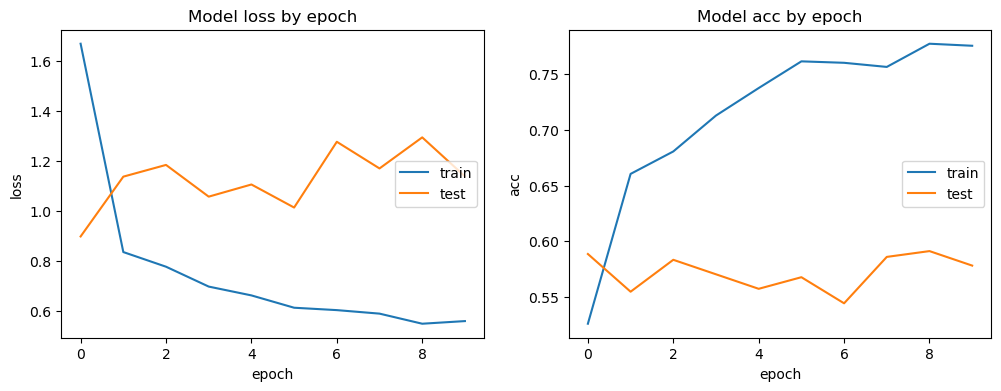

In [203]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


## Test prédictions 
A noter que la famille "Polyporaceae" et "Fomitopsidaceae" sont assz proches (gros parasite sur les tronc)

Nous avons d'abord utilisé le preprocess suivant avant d'appeler model.predict(img) :  
img = np.array(img).astype('float32')/255  
img = np.expand_dims(img, axis=0)  

Puis nous avons fini par trouver un format d'entrée compatible en utilisant preprocess_input(img) :  
img = image.img_to_array(img)  
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))  
img = preprocess_input(img)  

On affiche les probabilités du champignon testé avec les 4 classes puis le nom de la classe choisie
3 des 4 exemples sont correctement détectés ici mais ce premier modèle reste médiocre (ce qui est normal pour le moment !)


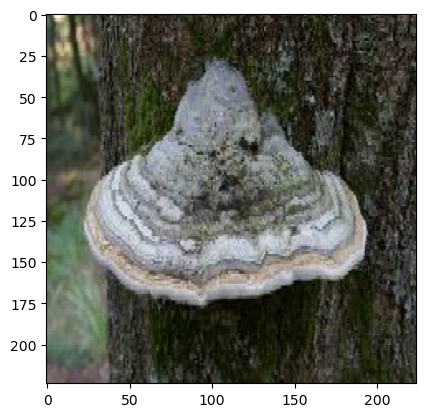

Probabilité pour les 4 classes : [[2.1506903e-04 1.5816028e-06 9.9460441e-01 5.1789992e-03]]
Classe présentie : Fomitopsidaceae


In [215]:
# Test prédiction 1

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('./Images/test/Polyporaceae/Fomes fomentarius32211.jpg',target_size=(224,224))
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

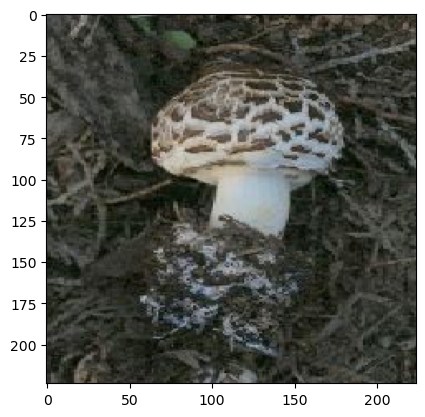

Probabilité pour les 4 classes : [[0.47298416 0.24727361 0.06540986 0.2143323 ]]
Classe présentie : Agaricaceae


In [216]:
# Test prédiction 2

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('./Images/test/Agaricaceae/Chlorophyllum brunneum1866.jpg',target_size=(224,224))
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

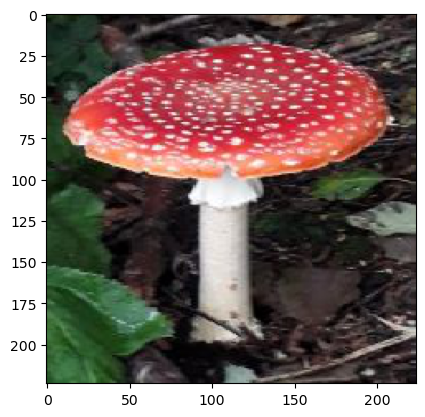

Probabilité pour les 4 classes : [[5.5361638e-06 9.9999166e-01 2.9180185e-06 1.0295273e-11]]
Classe présentie : Amanitaceae


In [217]:
# Test prédiction 3

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('./Images/test/Amanitaceae/Amanita muscaria14770.jpg',target_size=(224,224))
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])

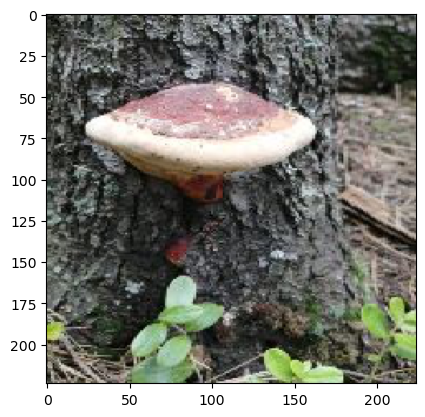

Probabilité pour les 4 classes : [[0.02290144 0.01532044 0.6137168  0.34806132]]
Classe présentie : Fomitopsidaceae


In [218]:
# Test prédiction 4

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('./Images/test/Fomitopsidaceae/Fomitopsis pinicola802.jpg',target_size=(224,224))
plt.imshow(img)
plt.show()

# 1ere solution de préprocessing
#img = np.array(img).astype('float32')/255
#img = np.expand_dims(img, axis=0)

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 4 classes :", output)
print("Classe présentie :", classes[output.argmax()])